In [1]:
import numpy as np
import sys
import time
import h5py
from tqdm import tqdm

import numpy as np
import re
from math import ceil
from sklearn.metrics import average_precision_score
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import pickle
#import pickle5 as pickle

from sklearn.model_selection import train_test_split

from scipy.sparse import load_npz
from glob import glob

#from transformers import get_constant_schedule_with_warmup
from sklearn.metrics import precision_score,recall_score,accuracy_score

#from src.train import trainModel
from src.dataloader import getData,spliceDataset,h5pyDataset,getDataPointList,getDataPointListFull,DataPoint
#from src.weight_init import keras_init
#rom src.losses import categorical_crossentropy_2d
#rom src.models import SpliceAI_10K
#from src.evaluation_metrics import print_topl_statistics
import copy
#import tensorflow as tf

In [2]:
rng = np.random.default_rng(23673)

In [3]:
data_dir = '../Data'

In [4]:
setType = 'test'
annotation, transcriptToLabel, seqData = getData(data_dir, setType)

In [5]:
L = 32
N_GPUS = 8
k = 2
# Hyper-parameters:
# L: Number of convolution kernels
# W: Convolution window size in each residual unit
# AR: Atrous rate in each residual unit

W = np.asarray([11, 11, 11, 11, 11, 11, 11, 11,
                21, 21, 21, 21, 41, 41, 41, 41])
AR = np.asarray([1, 1, 1, 1, 4, 4, 4, 4,
                 10, 10, 10, 10, 25, 25, 25, 25])
BATCH_SIZE = k*6*N_GPUS


CL = 2 * np.sum(AR*(W-1))

SL=5000
CL_max=10000

In [6]:
df1 = pd.read_csv('/odinn/users/gislih/RNA/requests/rna_paper/splice_anno/junction_db.tsv.gz', compression='gzip', sep='\t')
chroms = ['chr1', 'chr3', 'chr5', 'chr7', 'chr9']
df1 = df1[df1.Chrom.isin(chroms)]

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv1D, Cropping1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import add
import tensorflow.keras.backend as kb
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Lambda

def ResidualUnit(l, w, ar):
    # Residual unit proposed in "Identity mappings in Deep Residual Networks"
    # by He et al.

    def f(input_node):

        bn1 = BatchNormalization()(input_node)
        act1 = Activation('relu')(bn1)
        conv1 = Conv1D(l, [w], dilation_rate=[ar], padding='same')(act1)
        bn2 = BatchNormalization()(conv1)
        act2 = Activation('relu')(bn2)
        conv2 = Conv1D(l, [w], dilation_rate=[ar], padding='same')(act2)
        output_node = add([conv2, input_node])

        return output_node

    return f


def SpliceAI(L, W, AR):
    # L: Number of convolution kernels
    # W: Convolution window size in each residual unit
    # AR: Atrous rate in each residual unit

    assert len(W) == len(AR)

    CL = 2 * np.sum(AR*(W-1))

    input0 = Input(shape=(None, 4))
    conv = Conv1D(L, 1)(input0)
    skip = Conv1D(L, 1)(conv)

    for i in range(len(W)):
        conv = ResidualUnit(L, W[i], AR[i])(conv)
        
        if (((i+1) % 4 == 0) or ((i+1) == len(W))):
            # Skip connections to the output after every 4 residual units
            dense = Conv1D(L, 1)(conv)
            skip = add([skip, dense])

    skip = Cropping1D(int(CL/2))(skip)

    output0 = [[] for t in range(1)]

    for t in range(1):
        output0[t] = Conv1D(3, 1, activation='softmax')(skip)
    
    model = Model(inputs=input0, outputs=output0)

    return model


def categorical_crossentropy_2d(y_true, y_pred):
    # Standard categorical cross entropy for sequence outputs
    weights = [3.33445928e-01, 1.97431150e+03, 1.97432843e+03]
    return - kb.mean(weights[0]*y_true[:, :, 0]*kb.log(y_pred[:, :, 0]+1e-10)
                   + weights[1]*y_true[:, :, 1]*kb.log(y_pred[:, :, 1]+1e-10)
                   + weights[2]*y_true[:, :, 2]*kb.log(y_pred[:, :, 2]+1e-10))


2022-11-14 16:53:18.141412: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [8]:
from pkg_resources import resource_filename
from tensorflow.keras.models import load_model 

models = []
n_models = 5

paths = ('models/spliceai{}.h5'.format(x) for x in range(1, 6))
models = [load_model(resource_filename('spliceai', x)) for x in paths]

device = torch.device("cpu")

2022-11-14 16:53:20.712637: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-14 16:53:22.799580: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1666] Found device 0 with properties: 
name: NVIDIA A100-PCIE-40GB major: 8 minor: 0 memoryClockRate(GHz): 1.41
pciBusID: 0000:31:00.0
2022-11-14 16:53:22.799774: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1666] Found device 1 with properties: 
name: NVIDIA A100-PCIE-40GB major: 8 minor: 0 memoryClockRate(GHz): 1.41
pciBusID: 0000:98:00.0
2022-11-14 16:53:22.799919: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1666] Found device 2 with properties: 
name: NVIDIA A100-PCIE-40GB major: 8 minor: 0 memoryClockRate(GHz): 1.41
pciBusID: 0000:ca:00.0
2022-11-14 16:53:22.799954: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-11-14 16:53:22.804257: I tensorflow/stream_executor/platform/defau

In [9]:
import pyfastx
import os.path
data_dir = '../Data/'
fasta_file_path = '../Data/genome.fa'
gtf_file_path = '../Data/Homo_sapiens.GRCh38.87.gtf'
fasta = pyfastx.Fasta(fasta_file_path)

In [10]:
import gffutils
fname = data_dir+gtf_file_path.split('/')[-1][:-4]+'.db'
if not os.path.isfile(fname): 
    gffutils.create_db(gtf_file_path, fname, force=True, disable_infer_genes=True, disable_infer_transcripts=True)

gtf = gffutils.FeatureDB(fname)

In [11]:
lead_sQTL = pd.read_csv('/odinn/data/dataprocessing/rnasplice-blood/curry/sQTL_summary/lead_sQTL.gor', sep='\t')
lead_sQTL = lead_sQTL[lead_sQTL['Pos_bin']!='distant_downstream']
lead_sQTL = lead_sQTL[lead_sQTL['Pos_bin']!='distant_upstream']
lead_sQTL = lead_sQTL[lead_sQTL['REF']!=lead_sQTL['ALT']]
#lead_sQTL = lead_sQTL[lead_sQTL['Pval']<=0.05/lead_sQTL.shape[0]]
df1['splice_event_id'] = ['{}:{}:{}'.format(df1.iloc[i,0],df1.iloc[i,1],df1.iloc[i,2]) for i in range(df1.shape[0])]
def f(x):
    x = x.split(':')
    return '{}:{}:{}'.format(x[0],x[1],x[2])

lead_sQTL['splice_event_id'] = lead_sQTL['splice_event_id'].apply(f)
df = df1.merge(lead_sQTL,on='splice_event_id',how='left')

In [12]:
#df1 = df1[df1['protein_coding']==True]

In [13]:
def predictSplicing(seq,models):
    outputs = []
    for i in range(seq.shape[0]):
        Xc = torch.tensor(seq[i,:,:], device=device).float().unsqueeze(0).numpy()
        #Xc = torch.swapaxes(batch_features,1,2)
        predictions = []
        for v in range(n_models):
            Yp = models[v].predict(Xc, batch_size=1)
            predictions.append(Yp)
        predictions = (predictions[0]+predictions[1]+predictions[2]+predictions[3]+predictions[4])/n_models
        outputs.append(np.swapaxes(predictions,1,2))
    
    outputs = np.concatenate(outputs,axis=2)
    #outputs = outputs.cpu().detach().numpy()
    return outputs

def plotPrediction(outputs):
    plt.rcParams.update({'font.size': 18})
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(22, 6),sharex=True)
    x = np.arange(outputs.shape[2])
    ax1.plot(x,outputs[0,1,:],linewidth=2,zorder=-32)
    ax2.plot(x,outputs[0,2,:],linewidth=2,zorder=-32)
    plt.xlabel('Distance from transcript start (nt)')
    ax1.set_ylabel('Acceptor score')
    ax2.set_ylabel('Donor Score')
    ax1.legend(prop={'size': 14})
    ax2.legend(prop={'size': 14})
    plt.tight_layout()
    plt.show()

def ceil_div(x, y):

    return int(ceil(float(x)/y))


IN_MAP = np.asarray([[0, 0, 0, 0],
                     [1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])

def one_hot_encode(Xd):

    return IN_MAP[Xd.astype('int8')]

def reformat_data(X0):
    # This function converts X0, Y0 of the create_datapoints function into
    # blocks such that the data is broken down into data points where the
    # input is a sequence of length SL+CL_max corresponding to SL nucleotides
    # of interest and CL_max context nucleotides, the output is a sequence of
    # length SL corresponding to the splicing information of the nucleotides
    # of interest. The CL_max context nucleotides are such that they are
    # CL_max/2 on either side of the SL nucleotides of interest.

    num_points = ceil_div(len(X0)-CL_max, SL)
    Xd = np.zeros((num_points, SL+CL_max))
    X0 = np.pad(X0, [0, SL], 'constant', constant_values=0)

    for i in range(num_points):
        Xd[i] = X0[SL*i:CL_max+SL*(i+1)]

    return Xd

def seqToArray(seq,strand):
    seq = 'N'*(CL_max//2) + seq + 'N'*(CL_max//2)
    seq = seq.upper()
    seq = re.sub(r'[^AGTC]', '0',seq)
    seq = seq.replace('A', '1').replace('C', '2')
    seq = seq.replace('G', '3').replace('T', '4').replace('N', '0')
    if strand == '+':
        X0 = np.asarray([int(x) for x in seq])
            
    elif strand == '-':
        X0 = (5-np.asarray([int(x) for x in seq[::-1]])) % 5  # Reverse complement
        
    Xd = reformat_data(X0)
    return  one_hot_encode(Xd)
    
#acceptorDeltas = []
#donorDeltas = []
results = {}

for i in tqdm(range(df.shape[0])):
    #gtf['ENSG00000223972'][4]
    gene_ids = df['Gene_id'].iloc[i].split(',')
    chrm = df['Chrom_x'].iloc[i]
    #strand = df['Strand'].iloc[i]
    jn_start = df['Start'].iloc[i]
    jn_end = df['End_x'].iloc[i]
    
    #starts,ends = [],[]
    for gene_id in gene_ids:
        try:
            strand = gtf[gene_id][6]
            gene_start,gene_end = gtf[gene_id][3],gtf[gene_id][4]
            #starts.append(tmp[0])
            #ends.append(tmp[1])

        #gene_start,gene_end = np.min(starts),np.max(ends)

        #pos = df_gene['Pos'].iloc[0]
            start,end = np.max([np.max([1,jn_start-CL_max//2]),gene_start]),np.min([jn_end+CL_max//2,gene_end])
            if jn_start-start < 1:
                start = np.max([1,jn_start-CL_max//2])
            #if strand=='-':
            #    starts,ends = [],[]
            #    for i in range(df_gene.shape[0]):
            #        starts.append(pos+df_gene['acceptor'].iloc[i]-CL_max//2-SL//2)
            #        ends.append(pos+df_gene['donor'].iloc[i]+CL_max//2+SL//2)
            #    start2,end2 = np.min(starts),np.max(ends)
            #    start = np.min([start,start2])
            #    end = np.max([end,end2])
            #else:
            #    starts,ends = [],[]
            #    for i in range(df_gene.shape[0]):
            #        starts.append(pos-df_gene['donor'].iloc[i]-CL_max//2-SL//2)
            #        ends.append(pos-df_gene['acceptor'].iloc[i]+CL_max//2+SL//2)
            #    start2,end2 = np.min(starts),np.max(ends)
            #    start = np.min([start,start2])
            #    end = np.max([end,end2])

            #ref_s = df_gene['REF'].iloc[0]
            #alt_s = df_gene['ALT'].iloc[0]
            #pos_s = pos-start

            ref = fasta[chrm][start-1:end].seq
            ref_len2 = len(ref)
            has_sQTL = df['ALT'].iloc[i] == df['ALT'].iloc[i]
            if has_sQTL:
                alt = ref
                ref_s = df['REF'].iloc[i]
                alt_s = df['ALT'].iloc[i]
                pos = int(df['Pos'].iloc[i])
                pos_s = pos-start
                ref_len = len(ref_s)
                alt_len = len(alt_s)

                assert ref_s == ref[pos_s:(pos_s+ref_len)]
                alt = alt[:pos_s]+alt_s+alt[(pos_s+ref_len):]
                alt_align = np.arange(len(ref))
                alt_align = np.concatenate([alt_align[:pos_s],np.repeat(pos_s,alt_len),alt_align[pos_s+ref_len:]])
                alt_len2 = len(alt)
                alt = seqToArray(alt,strand)
                alt_prediction = predictSplicing(alt,models)[0,:,:alt_len2]

            ref = seqToArray(ref,strand)
            ref_prediction = predictSplicing(ref,models)[0,:,:ref_len2] 
            tmp = np.zeros_like(ref_prediction)

            if strand=='-':
                ref_prediction = ref_prediction[:,::-1]
                acceptor_loc =jn_start-start
                donor_loc = jn_end-start+1
                if has_sQTL:
                    alt_prediction = alt_prediction[:,::-1]
                    alt_prediction = np.concatenate([alt_prediction[:,:pos_s],ref_prediction[:,pos_s:pos_s+ref_len],alt_prediction[:,pos_s+alt_len:]],axis=1)
            else:
                acceptor_loc = jn_end-start+1
                donor_loc = jn_start-start

                if has_sQTL:
                    alt_prediction = np.concatenate([alt_prediction[:,:pos_s],ref_prediction[:,pos_s:pos_s+ref_len],alt_prediction[:,pos_s+alt_len:]],axis=1)

            ref_acceptor = ref_prediction[1,acceptor_loc]
            ref_donor = ref_prediction[2,donor_loc]
            #print(strand,df['is_annotated_x'].iloc[i],df['jct_sites'].iloc[i])
            #print(ref_acceptor[acceptor_loc],ref_donor[donor_loc])


            if has_sQTL:
                #print('Alt prediction ({})'.format(df['ALT'].iloc[i]))
                alt_acceptor = alt_prediction[1,acceptor_loc]
                alt_donor = alt_prediction[2,donor_loc]
                #print(alt_acceptor[acceptor_loc],alt_donor[donor_loc])
            else:
                alt_acceptor = float('nan')
                alt_donor = float('nan')

            results[df['splice_event_id'].iloc[i]] = [ref_acceptor,ref_donor,alt_acceptor,alt_donor]
            #plt.plot(ref_prediction[1,:])
            #plt.plot(alt_prediction[1,:])
        #plt.show()

     #   for i in range(df_gene.shape[0]):
     #       if strand=='-':
     #           acceptor_loc = df_gene['acceptor'].iloc[i]+pos_s
     #           donor_loc = df_gene['donor'].iloc[i]+pos_s
     #       else:
     #           acceptor_loc = pos_s-df_gene['acceptor'].iloc[i]
     #           donor_loc = pos_s-df_gene['donor'].iloc[i]

     #       acceptor_delta_nr = alt_acceptor.shape[0]-np.argsort(np.argsort(np.absolute(acceptorDelta)))[acceptor_loc]
     #       donor_delta_nr = alt_donor.shape[0]-np.argsort(np.argsort(np.absolute(donorDelta)))[donor_loc]
     #       top_a_creation_pos = np.argmax(acceptorDelta)
     #       top_d_creation_pos = np.argmax(donorDelta)
     #       top_a_disruption_pos = np.argmin(acceptorDelta)
     #       top_d_disruption_pos = np.argmin(donorDelta)
     #       top_a_creation_delta = acceptorDelta[top_a_creation_pos]
      #      top_d_creation_delta = donorDelta[top_d_creation_pos]
      #      top_a_disruption_delta = acceptorDelta[top_a_disruption_pos]
      #      top_d_disruption_delta = donorDelta[top_d_disruption_pos]

      #      results[df_gene['splice_event_id'].iloc[i]] = [acceptorDelta[acceptor_loc],donorDelta[donor_loc],ref_acceptor[acceptor_loc],ref_donor[donor_loc],alt_acceptor[acceptor_loc],alt_donor[donor_loc],acceptor_delta_nr,donor_delta_nr,start+top_a_creation_pos,start+top_d_creation_pos,start+top_a_disruption_pos,start+top_d_disruption_pos,top_a_creation_delta,top_d_creation_delta,top_a_disruption_delta,top_d_disruption_delta]
        except:
            print('{} failed'.format(gene_id))

  0%|                                                                                                                                                                                                                                      | 0/103197 [00:00<?, ?it/s]2022-11-14 16:53:44.523952: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-11-14 16:53:46.774560: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
  2%|████▌                                                                                                                                                                                                                    | 2169/103197 [05:52<4:28:02,  6.28it/s]

ENSG00000236266 failed


  3%|█████▌                                                                                                                                                                                                                  | 2644/103197 [09:24<15:54:54,  1.76it/s]

ENSG00000283611 failed


  3%|█████▉                                                                                                                                                                                                                  | 2845/103197 [11:29<25:50:27,  1.08it/s]

ENSG00000175279 failed


  3%|█████▉                                                                                                                                                                                                                  | 2846/103197 [11:30<30:47:49,  1.10s/it]

ENSG00000175279 failed


  3%|█████▉                                                                                                                                                                                                                  | 2847/103197 [11:32<38:56:56,  1.40s/it]

ENSG00000175279 failed


  3%|█████▉                                                                                                                                                                                                                  | 2855/103197 [11:41<30:42:02,  1.10s/it]

ENSG00000175279 failed


  3%|██████▏                                                                                                                                                                                                                 | 2970/103197 [13:13<29:36:46,  1.06s/it]

ENSG00000120948 failed


  4%|████████▉                                                                                                                                                                                                                | 4229/103197 [23:00<7:25:58,  3.70it/s]

ENSG00000280114 failed


  4%|████████▉                                                                                                                                                                                                               | 4243/103197 [23:06<16:35:24,  1.66it/s]

ENSG00000227684 failed


  4%|████████▉                                                                                                                                                                                                               | 4244/103197 [23:07<25:37:51,  1.07it/s]

ENSG00000227684 failed


  4%|████████▉                                                                                                                                                                                                               | 4245/103197 [23:09<33:32:38,  1.22s/it]

ENSG00000227684 failed


  5%|██████████▍                                                                                                                                                                                                             | 4968/103197 [25:44<25:00:29,  1.09it/s]

ENSG00000173436 failed


  6%|████████████                                                                                                                                                                                                             | 5721/103197 [28:30<5:05:18,  5.32it/s]

ENSG00000237200 failed


  7%|████████████████▏                                                                                                                                                                                                        | 7695/103197 [34:44<5:17:39,  5.01it/s]

ENSG00000242125 failed


  7%|████████████████▏                                                                                                                                                                                                        | 7697/103197 [34:45<5:27:53,  4.85it/s]

ENSG00000242125 failed


  9%|██████████████████▌                                                                                                                                                                                                     | 8894/103197 [38:54<25:38:38,  1.02it/s]

ENSG00000255811 failed


  9%|██████████████████▊                                                                                                                                                                                                      | 8924/103197 [39:02<7:48:35,  3.35it/s]

ENSG00000243749 failed


  9%|██████████████████▋                                                                                                                                                                                                     | 8956/103197 [39:13<10:31:15,  2.49it/s]

ENSG00000271741 failed


  9%|██████████████████▊                                                                                                                                                                                                      | 8961/103197 [39:15<8:33:45,  3.06it/s]

ENSG00000271741 failed


  9%|███████████████████▌                                                                                                                                                                                                     | 9332/103197 [40:28<7:29:37,  3.48it/s]

ENSG00000271554 failed


  9%|███████████████████▋                                                                                                                                                                                                     | 9334/103197 [40:28<6:12:38,  4.20it/s]

ENSG00000271554 failed


 10%|████████████████████▉                                                                                                                                                                                                   | 10033/103197 [42:36<4:00:01,  6.47it/s]

ENSG00000228436 failed


 14%|██████████████████████████████▏                                                                                                                                                                                         | 14395/103197 [58:33<2:56:35,  8.38it/s]

ENSG00000203965 failed


 14%|██████████████████████████████▍                                                                                                                                                                                         | 14553/103197 [59:21<9:51:20,  2.50it/s]

ENSG00000213625 failed
ENSG00000213625 failed


 14%|██████████████████████████████▎                                                                                                                                                                                        | 14555/103197 [59:26<29:51:22,  1.21s/it]

ENSG00000213625 failed


 14%|██████████████████████████████▎                                                                                                                                                                                        | 14556/103197 [59:29<44:50:21,  1.82s/it]

ENSG00000213625 failed


 14%|██████████████████████████████▎                                                                                                                                                                                        | 14559/103197 [59:30<19:17:43,  1.28it/s]

ENSG00000213625 failed


 15%|███████████████████████████████                                                                                                                                                                                       | 15004/103197 [1:01:05<2:15:22, 10.86it/s]

ENSG00000235782 failed


 15%|███████████████████████████████▏                                                                                                                                                                                      | 15044/103197 [1:01:20<8:19:41,  2.94it/s]

ENSG00000254685 failed


 15%|███████████████████████████████▍                                                                                                                                                                                      | 15177/103197 [1:01:53<4:52:39,  5.01it/s]

ENSG00000117054 failed


 15%|████████████████████████████████▍                                                                                                                                                                                     | 15661/103197 [1:04:12<3:28:17,  7.00it/s]

ENSG00000174021 failed
ENSG00000174021 failed


 15%|████████████████████████████████▍                                                                                                                                                                                     | 15665/103197 [1:04:13<4:22:23,  5.56it/s]

ENSG00000174021 failed


 16%|█████████████████████████████████▋                                                                                                                                                                                   | 16321/103197 [1:06:24<20:17:10,  1.19it/s]

ENSG00000230735 failed


 16%|██████████████████████████████████▌                                                                                                                                                                                  | 16764/103197 [1:08:17<22:48:53,  1.05it/s]

ENSG00000230439 failed


 16%|██████████████████████████████████▊                                                                                                                                                                                  | 16896/103197 [1:08:51<11:19:39,  2.12it/s]

ENSG00000152078 failed


 16%|██████████████████████████████████▉                                                                                                                                                                                  | 16897/103197 [1:08:52<13:29:33,  1.78it/s]

ENSG00000152078 failed


 16%|██████████████████████████████████▉                                                                                                                                                                                  | 16898/103197 [1:08:52<15:45:18,  1.52it/s]

ENSG00000152078 failed


 16%|██████████████████████████████████▉                                                                                                                                                                                  | 16899/103197 [1:08:56<35:35:33,  1.48s/it]

ENSG00000152078 failed


 18%|██████████████████████████████████████▌                                                                                                                                                                               | 18566/103197 [1:14:22<4:04:29,  5.77it/s]

ENSG00000282608 failed
ENSG00000282608 failed


 18%|██████████████████████████████████████▌                                                                                                                                                                               | 18624/103197 [1:14:40<3:17:39,  7.13it/s]

ENSG00000116473 failed


 19%|█████████████████████████████████████████▋                                                                                                                                                                            | 20092/103197 [1:18:59<2:59:08,  7.73it/s]

ENSG00000265241 failed


 19%|█████████████████████████████████████████▋                                                                                                                                                                            | 20121/103197 [1:19:08<4:35:36,  5.02it/s]

ENSG00000278431 failed
ENSG00000278431 failed


 21%|████████████████████████████████████████████▎                                                                                                                                                                         | 21344/103197 [1:22:12<3:19:49,  6.83it/s]

ENSG00000163154 failed
ENSG00000163154 failed


 21%|████████████████████████████████████████████▎                                                                                                                                                                         | 21346/103197 [1:22:12<4:11:15,  5.43it/s]

ENSG00000163154 failed
ENSG00000163154 failed


 21%|████████████████████████████████████████████▎                                                                                                                                                                         | 21347/103197 [1:22:12<4:12:37,  5.40it/s]

ENSG00000163154 failed


 21%|████████████████████████████████████████████▎                                                                                                                                                                         | 21348/103197 [1:22:13<4:47:00,  4.75it/s]

ENSG00000163154 failed


 21%|████████████████████████████████████████████▎                                                                                                                                                                         | 21375/103197 [1:22:17<3:45:52,  6.04it/s]

ENSG00000163157 failed


 21%|████████████████████████████████████████████▎                                                                                                                                                                         | 21382/103197 [1:22:19<4:43:12,  4.81it/s]

ENSG00000163157 failed


 21%|████████████████████████████████████████████▎                                                                                                                                                                         | 21387/103197 [1:22:20<4:49:43,  4.71it/s]

ENSG00000163157 failed


 21%|████████████████████████████████████████████▎                                                                                                                                                                         | 21388/103197 [1:22:20<5:20:51,  4.25it/s]

ENSG00000163157 failed


 21%|████████████████████████████████████████████▎                                                                                                                                                                         | 21391/103197 [1:22:20<4:07:48,  5.50it/s]

ENSG00000163157 failed


 22%|███████████████████████████████████████████████▎                                                                                                                                                                      | 22804/103197 [1:25:34<1:58:58, 11.26it/s]

ENSG00000232093 failed


 22%|███████████████████████████████████████████████▍                                                                                                                                                                      | 22869/103197 [1:25:42<4:07:10,  5.42it/s]

ENSG00000243364 failed


 23%|█████████████████████████████████████████████████▏                                                                                                                                                                   | 23824/103197 [1:27:55<15:35:51,  1.41it/s]

ENSG00000160783 failed


 23%|█████████████████████████████████████████████████▍                                                                                                                                                                    | 23851/103197 [1:28:04<7:52:56,  2.80it/s]

ENSG00000160783 failed


 23%|█████████████████████████████████████████████████▍                                                                                                                                                                    | 23855/103197 [1:28:06<6:22:12,  3.46it/s]

ENSG00000160783 failed


 23%|██████████████████████████████████████████████████▏                                                                                                                                                                   | 24209/103197 [1:28:49<3:53:28,  5.64it/s]

ENSG00000143321 failed


 23%|██████████████████████████████████████████████████▏                                                                                                                                                                   | 24210/103197 [1:28:49<3:36:30,  6.08it/s]

ENSG00000143321 failed


 24%|███████████████████████████████████████████████████▋                                                                                                                                                                  | 24949/103197 [1:30:39<2:56:55,  7.37it/s]

ENSG00000188004 failed


 24%|███████████████████████████████████████████████████▉                                                                                                                                                                  | 25055/103197 [1:30:52<2:35:01,  8.40it/s]

ENSG00000227741 failed
ENSG00000227741 failed


 24%|███████████████████████████████████████████████████▊                                                                                                                                                                 | 25107/103197 [1:31:11<15:26:31,  1.40it/s]

ENSG00000132716 failed


 24%|███████████████████████████████████████████████████▊                                                                                                                                                                 | 25114/103197 [1:31:15<14:40:53,  1.48it/s]

ENSG00000132716 failed


 24%|███████████████████████████████████████████████████▊                                                                                                                                                                 | 25115/103197 [1:31:16<13:20:58,  1.62it/s]

ENSG00000132716 failed


 24%|████████████████████████████████████████████████████                                                                                                                                                                  | 25135/103197 [1:31:19<1:55:14, 11.29it/s]

ENSG00000228606 failed
ENSG00000228606 failed


 25%|████████████████████████████████████████████████████▌                                                                                                                                                                | 25467/103197 [1:32:27<10:41:54,  2.02it/s]

ENSG00000158769 failed


 25%|████████████████████████████████████████████████████▌                                                                                                                                                                | 25468/103197 [1:32:27<10:33:42,  2.04it/s]

ENSG00000158769 failed


 25%|█████████████████████████████████████████████████████▊                                                                                                                                                                | 25938/103197 [1:33:40<2:18:24,  9.30it/s]

ENSG00000234211 failed


 26%|███████████████████████████████████████████████████████▌                                                                                                                                                              | 26773/103197 [1:36:55<2:46:52,  7.63it/s]

ENSG00000188404 failed


 26%|████████████████████████████████████████████████████████▏                                                                                                                                                             | 27117/103197 [1:37:58<3:06:52,  6.79it/s]

ENSG00000135845 failed
ENSG00000135845 failed


 28%|██████████████████████████████████████████████████████████▉                                                                                                                                                           | 28397/103197 [1:42:41<2:29:18,  8.35it/s]

ENSG00000116701 failed
ENSG00000116701 failed


 30%|███████████████████████████████████████████████████████████████▌                                                                                                                                                      | 30656/103197 [1:48:58<2:51:33,  7.05it/s]

ENSG00000266094 failed


 30%|███████████████████████████████████████████████████████████████▌                                                                                                                                                      | 30662/103197 [1:48:59<2:05:43,  9.62it/s]

ENSG00000266094 failed


 30%|███████████████████████████████████████████████████████████████▊                                                                                                                                                      | 30799/103197 [1:49:20<2:25:22,  8.30it/s]

ENSG00000180667 failed


 30%|████████████████████████████████████████████████████████████████▎                                                                                                                                                     | 30996/103197 [1:49:54<6:26:04,  3.12it/s]

ENSG00000244703 failed


 30%|████████████████████████████████████████████████████████████████▎                                                                                                                                                     | 31009/103197 [1:49:58<5:05:10,  3.94it/s]

ENSG00000244703 failed


 32%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 32776/103197 [1:55:14<4:56:11,  3.96it/s]

ENSG00000243709 failed


 32%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 32905/103197 [1:55:40<6:01:09,  3.24it/s]

ENSG00000228382 failed


 33%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 33729/103197 [1:57:58<5:54:33,  3.27it/s]

ENSG00000116918 failed


 33%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 33772/103197 [1:58:31<10:08:03,  1.90it/s]

ENSG00000226758 failed


 34%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 34665/103197 [2:01:39<6:14:15,  3.05it/s]

ENSG00000272865 failed


 34%|████████████████████████████████████████████████████████████████████████                                                                                                                                              | 34766/103197 [2:02:06<3:33:53,  5.33it/s]

ENSG00000054282 failed


 34%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 35499/103197 [2:05:02<1:56:24,  9.69it/s]

ENSG00000072756 failed


 35%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 36129/103197 [2:07:29<6:25:43,  2.90it/s]

ENSG00000241553 failed


 35%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 36133/103197 [2:07:30<6:35:26,  2.83it/s]

ENSG00000241553 failed
ENSG00000241553 failed


 35%|███████████████████████████████████████████████████████████████████████████                                                                                                                                           | 36216/103197 [2:07:56<9:54:02,  1.88it/s]

ENSG00000250151 failed


 36%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 37207/103197 [2:11:01<3:53:23,  4.71it/s]

ENSG00000170876 failed


 37%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 37810/103197 [2:13:04<3:06:53,  5.83it/s]

ENSG00000272529 failed


 37%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 38150/103197 [2:14:53<9:16:54,  1.95it/s]

ENSG00000225542 failed


 37%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 38152/103197 [2:14:53<6:36:56,  2.73it/s]

ENSG00000225542 failed


 37%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 38156/103197 [2:14:55<5:37:10,  3.22it/s]

ENSG00000225542 failed


 37%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 38656/103197 [2:17:29<2:47:21,  6.43it/s]

ENSG00000197385 failed
ENSG00000197385 failed
ENSG00000197385 failed


 37%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 38658/103197 [2:17:29<2:22:20,  7.56it/s]

ENSG00000197385 failed
ENSG00000197385 failed
ENSG00000197385 failed


 37%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 38660/103197 [2:17:30<2:09:02,  8.34it/s]

ENSG00000197385 failed


 38%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 38894/103197 [2:18:21<4:19:10,  4.14it/s]

ENSG00000188167 failed


 39%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 40238/103197 [2:22:09<4:39:42,  3.75it/s]

ENSG00000244607 failed


 39%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 40239/103197 [2:22:10<9:13:27,  1.90it/s]

ENSG00000244607 failed


 39%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 40272/103197 [2:22:25<4:14:04,  4.13it/s]

ENSG00000182983 failed


 39%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 40604/103197 [2:23:29<1:25:51, 12.15it/s]

ENSG00000169964 failed


 39%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 40612/103197 [2:23:30<2:13:01,  7.84it/s]

ENSG00000169964 failed


 40%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 40872/103197 [2:24:21<2:07:56,  8.12it/s]

ENSG00000163823 failed


 42%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 43203/103197 [2:30:24<5:09:28,  3.23it/s]

ENSG00000004534 failed


 42%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 43449/103197 [2:30:52<3:01:22,  5.49it/s]

ENSG00000114395 failed


 43%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 43923/103197 [2:32:12<5:41:12,  2.90it/s]

ENSG00000248487 failed


 43%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 43930/103197 [2:32:15<6:44:54,  2.44it/s]

ENSG00000248487 failed


 43%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 44008/103197 [2:32:27<3:46:40,  4.35it/s]

ENSG00000239732 failed


 43%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 44702/103197 [2:34:04<4:29:44,  3.61it/s]

ENSG00000055955 failed


 43%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 44797/103197 [2:34:36<5:27:18,  2.97it/s]

ENSG00000272305 failed


 45%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 46124/103197 [2:41:04<8:45:30,  1.81it/s]

ENSG00000277539 failed


 45%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 46599/103197 [2:43:06<3:18:41,  4.75it/s]

ENSG00000080822 failed


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 48075/103197 [2:48:34<5:40:34,  2.70it/s]

ENSG00000121577 failed


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 48808/103197 [2:50:40<5:54:45,  2.56it/s]

ENSG00000065485 failed


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 49736/103197 [2:54:05<11:16:36,  1.32it/s]

ENSG00000172780 failed


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 49737/103197 [2:54:06<10:42:00,  1.39it/s]

ENSG00000172780 failed


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 49747/103197 [2:54:11<5:01:08,  2.96it/s]

ENSG00000172780 failed


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 50503/103197 [2:58:20<9:51:54,  1.48it/s]

ENSG00000240303 failed


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 51139/103197 [3:04:42<11:23:18,  1.27it/s]

ENSG00000158092 failed


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 51140/103197 [3:04:45<17:40:44,  1.22s/it]

ENSG00000158092 failed


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 55076/103197 [3:39:27<6:31:28,  2.05it/s]

ENSG00000224563 failed
ENSG00000224563 failed


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 55078/103197 [3:39:28<4:10:29,  3.20it/s]

ENSG00000224563 failed
ENSG00000224563 failed


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 55080/103197 [3:39:28<2:56:52,  4.53it/s]

ENSG00000224563 failed


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 55219/103197 [3:40:18<3:34:24,  3.73it/s]

ENSG00000233308 failed
ENSG00000233308 failed


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 55220/103197 [3:40:18<3:16:35,  4.07it/s]

ENSG00000233308 failed


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 55221/103197 [3:40:18<3:23:47,  3.92it/s]

ENSG00000233308 failed


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 55942/103197 [3:42:57<3:20:05,  3.94it/s]

ENSG00000163959 failed


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 56007/103197 [3:43:21<6:29:39,  2.02it/s]

ENSG00000213123 failed
ENSG00000272741 failed


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 56117/103197 [3:43:52<4:21:10,  3.00it/s]

ENSG00000174004 failed


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 56118/103197 [3:43:52<4:19:46,  3.02it/s]

ENSG00000174004 failed


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 56119/103197 [3:43:53<4:42:32,  2.78it/s]

ENSG00000174004 failed


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 56120/103197 [3:43:53<6:32:40,  2.00it/s]

ENSG00000174004 failed


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 56121/103197 [3:43:54<6:45:43,  1.93it/s]

ENSG00000174004 failed


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 56122/103197 [3:43:55<6:53:17,  1.90it/s]

ENSG00000174004 failed


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 56123/103197 [3:43:55<7:27:00,  1.76it/s]

ENSG00000174004 failed


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 56124/103197 [3:43:56<10:06:19,  1.29it/s]

ENSG00000174004 failed


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 56125/103197 [3:43:58<12:36:52,  1.04it/s]

ENSG00000174004 failed


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 56159/103197 [3:44:07<1:52:25,  6.97it/s]

ENSG00000174007 failed


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 56666/103197 [3:45:48<2:28:42,  5.22it/s]

ENSG00000260774 failed


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 58155/103197 [3:50:53<4:10:23,  3.00it/s]

ENSG00000242110 failed
ENSG00000242110 failed


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 58165/103197 [3:50:56<4:18:16,  2.91it/s]

ENSG00000082196 failed


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 58166/103197 [3:50:56<4:31:40,  2.76it/s]

ENSG00000082196 failed


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 58876/103197 [3:53:44<1:54:37,  6.44it/s]

ENSG00000171522 failed
ENSG00000171522 failed


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 59311/103197 [3:55:31<4:39:22,  2.62it/s]

ENSG00000152684 failed


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 59312/103197 [3:55:32<5:29:26,  2.22it/s]

ENSG00000152684 failed


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 60076/103197 [3:59:13<3:23:28,  3.53it/s]

ENSG00000068796 failed


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 60086/103197 [3:59:16<4:11:24,  2.86it/s]

ENSG00000186105 failed


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 60087/103197 [3:59:17<3:57:33,  3.02it/s]

ENSG00000186105 failed


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 60234/103197 [3:59:48<2:30:43,  4.75it/s]

ENSG00000253251 failed


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 61106/103197 [4:02:45<1:24:08,  8.34it/s]

ENSG00000049860 failed


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 61318/103197 [4:03:27<2:07:19,  5.48it/s]

ENSG00000250348 failed


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 62546/103197 [4:09:13<2:23:22,  4.73it/s]

ENSG00000270133 failed


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 62911/103197 [4:10:38<1:30:53,  7.39it/s]

ENSG00000153113 failed
ENSG00000153113 failed
ENSG00000153113 failed


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 62913/103197 [4:10:39<1:20:57,  8.29it/s]

ENSG00000153113 failed
ENSG00000153113 failed


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 63056/103197 [4:11:07<1:15:02,  8.91it/s]

ENSG00000246763 failed


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 63592/103197 [4:13:26<3:42:29,  2.97it/s]

ENSG00000153037 failed
ENSG00000258864 failed


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 63595/103197 [4:13:28<4:37:40,  2.38it/s]

ENSG00000153037 failed
ENSG00000258864 failed


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 63598/103197 [4:13:29<4:15:01,  2.59it/s]

ENSG00000153037 failed
ENSG00000258864 failed


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 63599/103197 [4:13:30<4:36:54,  2.38it/s]

ENSG00000153037 failed
ENSG00000258864 failed


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 63600/103197 [4:13:30<4:42:09,  2.34it/s]

ENSG00000153037 failed
ENSG00000258864 failed


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 63760/103197 [4:14:05<7:42:59,  1.42it/s]

ENSG00000243414 failed


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 63761/103197 [4:14:06<7:52:38,  1.39it/s]

ENSG00000243414 failed


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 63892/103197 [4:15:01<4:42:31,  2.32it/s]

ENSG00000248445 failed


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 63907/103197 [4:15:04<1:29:21,  7.33it/s]

ENSG00000248445 failed


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 64610/103197 [4:18:34<3:23:42,  3.16it/s]

ENSG00000239642 failed


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 64931/103197 [4:19:40<1:08:55,  9.25it/s]

ENSG00000205089 failed


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 65188/103197 [4:20:27<2:27:19,  4.30it/s]

ENSG00000113558 failed


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 65460/103197 [4:21:33<5:39:54,  1.85it/s]

ENSG00000132570 failed


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 65942/103197 [4:23:14<4:33:15,  2.27it/s]

ENSG00000281398 failed


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 65947/103197 [4:23:15<2:44:59,  3.76it/s]

ENSG00000281398 failed


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 65948/103197 [4:23:15<2:51:44,  3.61it/s]

ENSG00000281398 failed


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 65949/103197 [4:23:16<6:08:20,  1.69it/s]

ENSG00000281398 failed


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 65950/103197 [4:23:18<9:53:55,  1.05it/s]

ENSG00000281398 failed


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 66250/103197 [4:24:42<2:44:04,  3.75it/s]

ENSG00000131503 failed


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 66451/103197 [4:25:18<46:42, 13.11it/s]

ENSG00000256453 failed
ENSG00000256453 failed


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 67442/103197 [4:31:25<50:19, 11.84it/s]

ENSG00000253865 failed


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 68134/103197 [4:33:26<6:18:43,  1.54it/s]

ENSG00000037749 failed


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 70191/103197 [4:40:22<1:30:21,  6.09it/s]

ENSG00000169228 failed


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 70194/103197 [4:40:23<1:31:34,  6.01it/s]

ENSG00000169228 failed


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 70710/103197 [4:41:42<53:44, 10.07it/s]

ENSG00000197451 failed


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 70712/103197 [4:41:42<54:34,  9.92it/s]

ENSG00000197451 failed


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 72021/103197 [4:45:59<4:32:51,  1.90it/s]

ENSG00000105963 failed


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 72081/103197 [4:46:14<1:14:36,  6.95it/s]

ENSG00000164849 failed


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 73021/103197 [4:49:39<3:03:13,  2.74it/s]

ENSG00000237738 failed
ENSG00000237738 failed


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 73022/103197 [4:49:40<3:51:27,  2.17it/s]

ENSG00000237738 failed


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 73721/103197 [4:52:50<2:58:21,  2.75it/s]

ENSG00000234141 failed


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 75065/103197 [4:59:06<2:31:17,  3.10it/s]

ENSG00000180233 failed


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 75140/103197 [4:59:23<2:20:16,  3.33it/s]

ENSG00000006625 failed


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 75141/103197 [4:59:24<3:19:34,  2.34it/s]

ENSG00000006625 failed


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 75143/103197 [4:59:25<4:12:14,  1.85it/s]

ENSG00000006625 failed


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 75144/103197 [4:59:26<4:37:28,  1.69it/s]

ENSG00000006625 failed


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 75740/103197 [5:01:35<47:39,  9.60it/s]

ENSG00000230539 failed
ENSG00000230539 failed


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 75743/103197 [5:01:36<1:21:51,  5.59it/s]

ENSG00000230539 failed


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 75855/103197 [5:02:34<19:28:30,  2.56s/it]

ENSG00000187037 failed


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 75856/103197 [5:02:43<32:54:43,  4.33s/it]

ENSG00000187037 failed


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 75857/103197 [5:02:49<38:40:45,  5.09s/it]

ENSG00000187037 failed


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 75858/103197 [5:02:54<37:54:44,  4.99s/it]

ENSG00000187037 failed


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 75859/103197 [5:03:04<49:15:36,  6.49s/it]

ENSG00000187037 failed


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 75870/103197 [5:03:13<9:22:17,  1.23s/it]

ENSG00000187037 failed


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 75887/103197 [5:03:25<7:56:52,  1.05s/it]

ENSG00000187037 failed


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 75888/103197 [5:03:26<8:21:25,  1.10s/it]

ENSG00000187037 failed


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 75889/103197 [5:03:27<8:38:21,  1.14s/it]

ENSG00000187037 failed


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 75890/103197 [5:03:30<12:44:18,  1.68s/it]

ENSG00000187037 failed


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 75891/103197 [5:03:34<18:26:03,  2.43s/it]

ENSG00000187037 failed


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 75892/103197 [5:03:37<19:55:03,  2.63s/it]

ENSG00000187037 failed


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 75893/103197 [5:03:41<21:51:18,  2.88s/it]

ENSG00000187037 failed


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 75894/103197 [5:03:44<23:03:31,  3.04s/it]

ENSG00000187037 failed


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 75895/103197 [5:03:48<23:53:39,  3.15s/it]

ENSG00000187037 failed


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 75896/103197 [5:03:54<30:32:51,  4.03s/it]

ENSG00000187037 failed


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 75897/103197 [5:03:57<29:38:17,  3.91s/it]

ENSG00000187037 failed


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 76414/103197 [5:06:21<3:05:00,  2.41it/s]

ENSG00000270617 failed


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 76489/103197 [5:06:45<1:52:36,  3.95it/s]

ENSG00000239556 failed


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 76491/103197 [5:06:46<3:57:25,  1.87it/s]

ENSG00000239556 failed


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 76494/103197 [5:06:47<2:27:31,  3.02it/s]

ENSG00000239556 failed


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 76495/103197 [5:06:47<2:12:53,  3.35it/s]

ENSG00000239556 failed


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 76496/103197 [5:06:48<2:47:44,  2.65it/s]

ENSG00000239556 failed


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 76497/103197 [5:06:48<3:13:23,  2.30it/s]

ENSG00000239556 failed
ENSG00000239556 failed


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 76499/103197 [5:06:49<3:43:12,  1.99it/s]

ENSG00000239556 failed
ENSG00000239556 failed


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 76509/103197 [5:06:54<2:34:28,  2.88it/s]

ENSG00000228434 failed


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 76511/103197 [5:06:55<2:49:06,  2.63it/s]

ENSG00000228434 failed


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 76620/103197 [5:07:12<45:03,  9.83it/s]

ENSG00000239775 failed
ENSG00000239775 failed


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 78025/103197 [5:11:28<1:23:45,  5.01it/s]

ENSG00000126522 failed


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 78026/103197 [5:11:28<1:46:32,  3.94it/s]

ENSG00000126522 failed


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 78139/103197 [5:12:04<47:41,  8.76it/s]

ENSG00000179406 failed
ENSG00000179406 failed


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 78192/103197 [5:12:16<1:05:34,  6.36it/s]

ENSG00000244657 failed
ENSG00000244657 failed


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 78201/103197 [5:12:17<1:16:50,  5.42it/s]

ENSG00000229180 failed


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 78226/103197 [5:12:21<1:13:19,  5.68it/s]

ENSG00000226824 failed
ENSG00000226824 failed


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 78227/103197 [5:12:21<1:13:29,  5.66it/s]

ENSG00000226824 failed


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 78230/103197 [5:12:23<2:36:46,  2.65it/s]

ENSG00000226824 failed


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 78336/103197 [5:12:49<58:01,  7.14it/s]

ENSG00000126524 failed


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 79546/103197 [5:16:41<5:57:45,  1.10it/s]

ENSG00000259628 failed


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 79547/103197 [5:16:42<6:33:23,  1.00it/s]

ENSG00000259628 failed


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 80282/103197 [5:19:06<2:22:01,  2.69it/s]

ENSG00000251154 failed


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 81013/103197 [5:21:29<50:27,  7.33it/s]

ENSG00000164713 failed


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 81280/103197 [5:22:15<36:42,  9.95it/s]

ENSG00000130429 failed
ENSG00000130429 failed


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 81452/103197 [5:22:50<3:00:14,  2.01it/s]

ENSG00000197343 failed


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 81453/103197 [5:22:50<3:07:18,  1.93it/s]

ENSG00000197343 failed


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 81454/103197 [5:22:51<4:03:28,  1.49it/s]

ENSG00000197343 failed


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 81942/103197 [5:24:01<1:38:56,  3.58it/s]

ENSG00000235333 failed


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 81943/103197 [5:24:02<1:38:23,  3.60it/s]

ENSG00000235333 failed


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 81945/103197 [5:24:02<1:38:18,  3.60it/s]

ENSG00000235333 failed


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 81946/103197 [5:24:02<1:39:31,  3.56it/s]

ENSG00000235333 failed


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 81947/103197 [5:24:03<1:42:51,  3.44it/s]

ENSG00000235333 failed


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 81948/103197 [5:24:03<1:43:12,  3.43it/s]

ENSG00000235333 failed


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 82081/103197 [5:24:27<46:13,  7.61it/s]

ENSG00000185955 failed


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 82082/103197 [5:24:28<54:16,  6.48it/s]

ENSG00000185955 failed


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 82783/103197 [5:26:18<1:24:28,  4.03it/s]

ENSG00000239969 failed


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 82784/103197 [5:26:18<1:35:14,  3.57it/s]

ENSG00000239969 failed


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 82785/103197 [5:26:19<1:59:00,  2.86it/s]

ENSG00000239969 failed


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 82786/103197 [5:26:20<2:26:06,  2.33it/s]

ENSG00000239969 failed


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 82787/103197 [5:26:20<2:44:29,  2.07it/s]

ENSG00000239969 failed


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 82964/103197 [5:26:46<2:13:13,  2.53it/s]

ENSG00000272949 failed


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 82965/103197 [5:26:47<2:06:59,  2.66it/s]

ENSG00000272949 failed


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 82967/103197 [5:26:48<2:09:51,  2.60it/s]

ENSG00000272949 failed


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 83011/103197 [5:27:01<1:44:03,  3.23it/s]

ENSG00000205236 failed
ENSG00000267368 failed


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 83370/103197 [5:28:07<38:19,  8.62it/s]

ENSG00000005483 failed


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 84693/103197 [5:34:03<1:12:57,  4.23it/s]

ENSG00000273184 failed


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 84696/103197 [5:34:04<1:09:25,  4.44it/s]

ENSG00000273184 failed


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 87657/103197 [5:43:55<1:05:45,  3.94it/s]

ENSG00000281887 failed


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 88403/103197 [5:45:53<27:50,  8.86it/s]

ENSG00000214106 failed


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 89789/103197 [5:50:55<9:12:43,  2.47s/it]

ENSG00000224972 failed


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 89815/103197 [5:51:11<3:32:35,  1.05it/s]

ENSG00000274527 failed


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 89816/103197 [5:51:13<3:50:06,  1.03s/it]

ENSG00000282960 failed


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 89819/103197 [5:51:16<4:27:41,  1.20s/it]

ENSG00000274527 failed
ENSG00000282960 failed


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 89820/103197 [5:51:18<4:46:22,  1.28s/it]

ENSG00000274527 failed
ENSG00000282960 failed


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 90983/103197 [5:55:23<34:12,  5.95it/s]

ENSG00000228352 failed


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 91471/103197 [5:56:33<11:24, 17.13it/s]

ENSG00000159884 failed


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 91758/103197 [5:57:07<17:08, 11.13it/s]

ENSG00000204930 failed


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 91760/103197 [5:57:07<18:39, 10.21it/s]

ENSG00000204930 failed


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 92122/103197 [5:58:53<1:42:53,  1.79it/s]

ENSG00000147912 failed


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 92123/103197 [5:58:54<1:58:57,  1.55it/s]

ENSG00000147912 failed


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 92174/103197 [5:59:05<1:18:14,  2.35it/s]

ENSG00000107371 failed


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 93949/103197 [6:05:35<31:40,  4.87it/s]

ENSG00000186354 failed


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 93950/103197 [6:05:36<33:29,  4.60it/s]

ENSG00000186354 failed


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 95447/103197 [6:10:23<17:29,  7.39it/s]

ENSG00000095380 failed


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 95757/103197 [6:11:26<30:02,  4.13it/s]

ENSG00000066697 failed


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 96609/103197 [6:14:19<11:38,  9.44it/s]

ENSG00000136867 failed
ENSG00000136867 failed


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 97611/103197 [6:17:28<10:26,  8.92it/s]

ENSG00000227355 failed
ENSG00000227355 failed


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 98818/103197 [6:21:59<07:00, 10.40it/s]

ENSG00000225032 failed
ENSG00000225032 failed
ENSG00000225032 failed


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 98857/103197 [6:22:06<13:00,  5.56it/s]

ENSG00000257524 failed


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 102120/103197 [6:30:29<03:47,  4.74it/s]

ENSG00000244187 failed


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 102152/103197 [6:30:37<05:20,  3.26it/s]

ENSG00000273066 failed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103197/103197 [6:33:11<00:00,  4.37it/s]


In [14]:
with open('/odinn/tmp/benediktj/Data/SplicePrediction-050422/novel_splice_sites_spliceai_pretrained.pkl', 'wb') as f:
    pickle.dump(results, f)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np

In [7]:
with open('/odinn/tmp/benediktj/Data/SplicePrediction-050422/novel_splice_sites_spliceai_pretrained.pkl', 'rb') as f:
    splice_ai_results = pickle.load(f)

In [8]:
#splice_ai_results = results

NameError: name 'results' is not defined

In [10]:
df2 = pd.DataFrame(splice_ai_results).T
df2.columns = ['ref_acceptor','ref_donor','alt_acceptor','alt_donor']
df2.index.name = 'splice_event_id'


In [11]:
df2

,ref_acceptor,ref_donor,alt_acceptor,alt_donor
splice_event_id,,,,
chr1:12721:13402,0.471970,0.271217,NaN,NaN
chr1:13052:13220,0.056682,0.005326,NaN,NaN
chr1:182746:183015,0.095083,0.574325,NaN,NaN
chr1:182746:183113,0.087244,0.574325,NaN,NaN
chr1:182746:183131,0.589252,0.574325,NaN,NaN
...,...,...,...,...
chr9:138175522:138175600,0.921316,0.406088,NaN,NaN
chr9:138175711:138176206,0.987783,0.924636,NaN,NaN
chr9:138175901:138176038,0.441126,0.617966,NaN,NaN


In [12]:
df2

,ref_acceptor,ref_donor,alt_acceptor,alt_donor
splice_event_id,,,,
chr1:12721:13402,0.471970,0.271217,NaN,NaN
chr1:13052:13220,0.056682,0.005326,NaN,NaN
chr1:182746:183015,0.095083,0.574325,NaN,NaN
chr1:182746:183113,0.087244,0.574325,NaN,NaN
chr1:182746:183131,0.589252,0.574325,NaN,NaN
...,...,...,...,...
chr9:138175522:138175600,0.921316,0.406088,NaN,NaN
chr9:138175711:138176206,0.987783,0.924636,NaN,NaN
chr9:138175901:138176038,0.441126,0.617966,NaN,NaN


In [16]:
df1 = pd.read_csv('/odinn/users/gislih/RNA/requests/rna_paper/splice_anno/junction_db.tsv.gz', compression='gzip', sep='\t')
chroms = ['chr1', 'chr3', 'chr5', 'chr7', 'chr9']
df1 = df1[df1.Chrom.isin(chroms)]

In [17]:
df1['splice_event_id'] = ['{}:{}:{}'.format(df1.iloc[i,0],df1.iloc[i,1],df1.iloc[i,2]) for i in range(df1.shape[0])]

In [18]:
results = df2.merge(df1,on='splice_event_id')[['ref_acceptor','ref_donor','alt_acceptor','alt_donor','jct_sites']]

In [19]:
results[results['jct_sites']=='novel_acceptor']

,ref_acceptor,ref_donor,alt_acceptor,alt_donor,jct_sites
0,0.471970,0.271217,NaN,NaN,novel_acceptor
2,0.095083,0.574325,NaN,NaN,novel_acceptor
4,0.589252,0.574325,NaN,NaN,novel_acceptor
5,0.126997,0.574325,NaN,NaN,novel_acceptor
7,0.082952,0.264501,NaN,NaN,novel_acceptor
...,...,...,...,...,...
103008,0.819687,0.888411,NaN,NaN,novel_acceptor
103037,0.347918,0.877052,NaN,NaN,novel_acceptor
103057,0.974764,0.997718,NaN,NaN,novel_acceptor
103076,0.009249,0.997876,NaN,NaN,novel_acceptor


In [20]:
results['max_acceptor'] = np.max(results[['ref_acceptor','alt_acceptor']],axis=1)
results['max_donor'] = np.max(results[['ref_donor','alt_donor']],axis=1)

In [21]:
results[results['jct_sites']=='novel_acceptor'].dropna()

,ref_acceptor,ref_donor,alt_acceptor,alt_donor,jct_sites,max_acceptor,max_donor
30,0.160512,0.983850,0.167716,0.976638,novel_acceptor,0.167716,0.983850
31,0.004181,0.983850,0.001837,0.976638,novel_acceptor,0.004181,0.983850
46,0.009723,0.933124,0.009446,0.933602,novel_acceptor,0.009723,0.933602
65,0.327009,0.996758,0.730474,0.996478,novel_acceptor,0.730474,0.996758
66,0.033730,0.996758,0.060297,0.996732,novel_acceptor,0.060297,0.996758
...,...,...,...,...,...,...,...
102803,0.000032,0.994218,0.698658,0.994260,novel_acceptor,0.698658,0.994260
102872,0.075702,0.990943,0.075078,0.990470,novel_acceptor,0.075702,0.990943
102887,0.028738,0.969423,0.007089,0.969423,novel_acceptor,0.028738,0.969423
102922,0.000004,0.970453,0.183268,0.974348,novel_acceptor,0.183268,0.974348


In [22]:
results[results['jct_sites']=='novel_donor'].dropna()

,ref_acceptor,ref_donor,alt_acceptor,alt_donor,jct_sites,max_acceptor,max_donor
39,0.996167,0.000039,0.996256,0.000042,novel_donor,0.996256,0.000042
78,0.901510,0.197980,0.902094,0.193524,novel_donor,0.902094,0.197980
171,0.923628,0.006798,0.944706,0.982260,novel_donor,0.944706,0.982260
282,0.988573,0.150975,0.988356,0.201911,novel_donor,0.988573,0.201911
299,0.992425,0.499281,0.995320,0.591696,novel_donor,0.995320,0.591696
...,...,...,...,...,...,...,...
102488,0.989647,0.210802,0.989647,0.208679,novel_donor,0.989647,0.210802
102671,0.998800,0.130220,0.998794,0.127497,novel_donor,0.998800,0.130220
102717,0.995853,0.614399,0.995804,0.613386,novel_donor,0.995853,0.614399
102743,0.982471,0.364820,0.976961,0.668464,novel_donor,0.982471,0.668464


In [23]:
results[results['jct_sites']=='both_novel'].dropna()

,ref_acceptor,ref_donor,alt_acceptor,alt_donor,jct_sites,max_acceptor,max_donor
198,4.589969e-05,3.283175e-06,4.329609e-05,3.270027e-06,both_novel,4.589969e-05,3.283175e-06
243,8.503602e-10,1.096337e-09,1.175099e-09,1.345221e-09,both_novel,1.175099e-09,1.345221e-09
615,1.930509e-02,4.804079e-03,3.908878e-02,1.270145e-02,both_novel,3.908878e-02,1.270145e-02
750,1.758900e-05,2.399337e-06,1.743190e-05,2.272608e-06,both_novel,1.758900e-05,2.399337e-06
752,1.407285e-06,2.399337e-06,1.381440e-06,2.272608e-06,both_novel,1.407285e-06,2.399337e-06
...,...,...,...,...,...,...,...
101604,2.081197e-08,1.676830e-05,2.089726e-08,1.678701e-05,both_novel,2.089726e-08,1.678701e-05
101605,2.081197e-08,1.218630e-05,2.081197e-08,1.198999e-05,both_novel,2.081197e-08,1.218630e-05
101614,1.504980e-01,1.068390e-01,1.005372e-01,1.034013e-01,both_novel,1.504980e-01,1.068390e-01
101628,6.005781e-02,3.197892e-02,5.917946e-02,3.205248e-02,both_novel,6.005781e-02,3.205248e-02


In [24]:
jct_type = results[results['jct_sites']=='novel_acceptor']
novel_acceptor_ratio = np.sum(jct_type['max_acceptor']>0.1)/jct_type.shape[0]
jct_type = results[results['jct_sites']=='novel_donor']
novel_donor_ratio = np.sum(jct_type['max_donor']>0.1)/jct_type.shape[0]
jct_type = results[results['jct_sites']=='both_novel']
both_novel_acceptor_ratio = np.sum(jct_type['max_acceptor']>0.1)/jct_type.shape[0]
jct_type = results[results['jct_sites']=='both_novel']
both_novel_donor_ratio = np.sum(jct_type['max_donor']>0.1)/jct_type.shape[0]
jct_type = results[results['jct_sites']=='both_annotated']
both_annotated_acceptor_ratio = np.sum(jct_type['max_acceptor']>0.1)/jct_type.shape[0]
jct_type = results[results['jct_sites']=='both_annotated']
both_annotated_donor_ratio = np.sum(jct_type['max_donor']>0.1)/jct_type.shape[0]

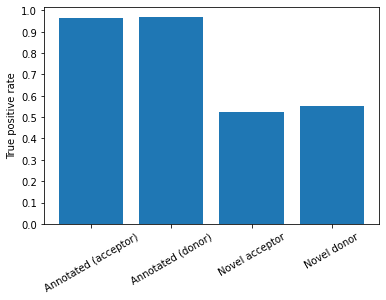

In [25]:
plt.bar(['Annotated (acceptor)','Annotated (donor)','Novel acceptor','Novel donor'],[both_annotated_acceptor_ratio,both_annotated_donor_ratio,novel_acceptor_ratio,novel_donor_ratio])
plt.xticks(rotation=30)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('True positive rate')
plt.show()

In [26]:
both_annotated_acceptor_ratio,both_annotated_donor_ratio,novel_acceptor_ratio,novel_donor_ratio

(0.9629669634453069,
 0.9693551622509914,
 0.5243971541900145,
 0.5523727755229473)

In [27]:
(0.9629669634453069+0.9693551622509914)/2

0.9661610628481492

In [28]:
(0.5243971541900145+0.5523727755229473)/2

0.5383849648564809